In [1]:
import matplotlib.pyplot as plt
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=18, titlepad=10)
plt.rc("animation", html="html5")

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

In [2]:
from tensorflow import keras
from tensorflow.keras import callbacks, layers

spotify = pd.read_csv("./spotify.csv")

X = spotify.copy().dropna()
y = X.pop("track_popularity")
artists = X["track_artist"]

numerical_columns = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]
categorical_columns = [col for col in X.columns if X[col].dtype == "object" and X[col].nunique() < 10]




In [3]:
print([item for item in numerical_columns  if item not in features_num])
print(categorical_columns)

NameError: name 'features_num' is not defined

In [5]:
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_columns),
    (OneHotEncoder(), categorical_columns)
)

# splitting the songs by artist prevents signal leakage

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_valid = y_valid / 100
y_train = y_train / 100 # scale from 0-100 to 0-1

In [6]:
input_shape =[X_train.shape[1]]

<Axes: >

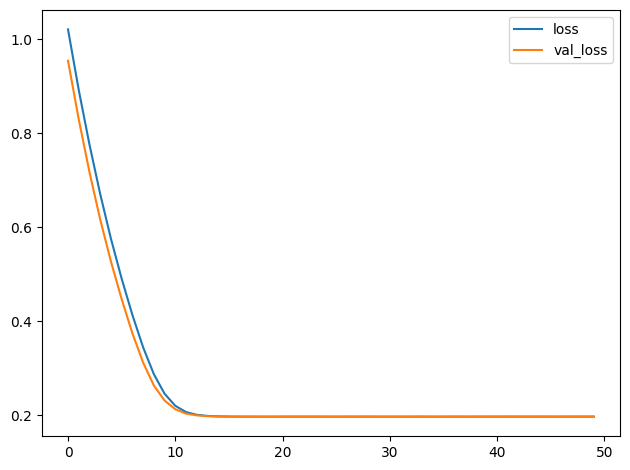

In [7]:
model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Dense(1)
])
model.compile(optimizer="adam", loss="mae")

history = model.fit(
    X_train, y_train, validation_data = (X_valid, y_valid), batch_size=512, epochs=50, verbose=0
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ["loss", "val_loss"]].plot()


min validationloss = 0.1961


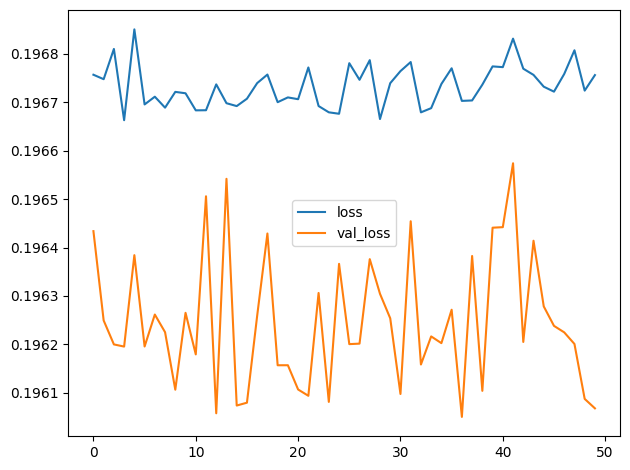

In [8]:
model2 = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mae")
history = model.fit(
    X_train, y_train, verbose=0, validation_data=(X_valid, y_valid), batch_size=512, epochs=50
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ["loss", "val_loss"]].plot()
print("min validationloss = {:0.4f}".format(history_df["val_loss"].min()))


In [42]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001,
    patience= 50,
    restore_best_weights=True
)

model_3 = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=1)
    
])

model_3.compile(
    optimizer="adam", loss="mae"
)

history_3 = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                      callbacks=[early_stopping], verbose=0, batch_size=512, epochs=50)

minimum loss is: 0.1969684362411499


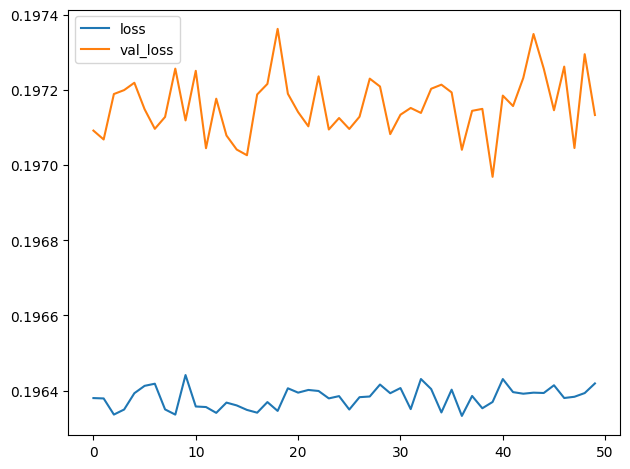

In [44]:
history_3_df = pd.DataFrame(history_3.history)
history_3_df.loc[:, ["loss", "val_loss"]].plot()
print(f"minimum loss is: {history_3_df["val_loss"].min()}")